 - combinar las tablas
 - limpiar datos
 - combinar las columnas title, brand, summary, description en una nueva columna
 - tokenizar la nueva columnas combinada
 - calcular similitud con la similitud de los items tokenizados del coseno
 - los que son muy similares los eliminamos de la lista
 - agarramos algunos items de la lista y calculamos el mean del overall
 - ordenamos nuevamente descendentemente pero esta vez basados en el overall mean => lista2
 - recomendamos los 10 primeros de la lista 2



In [3]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from skfuzzy import control as ctrl

In [4]:
PATH = './AMAZON_FASHION.json.gz'
PATH_meta = './meta_AMAZON_FASHION.json.gz'

## MODULO 1
### Lector de datasets

In [5]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [6]:
df = getDF(PATH)
df_meta = getDF(PATH_meta)

In [7]:
df_meta.shape

(186637, 16)

In [8]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [9]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

Text(0, 0.5, 'Count')

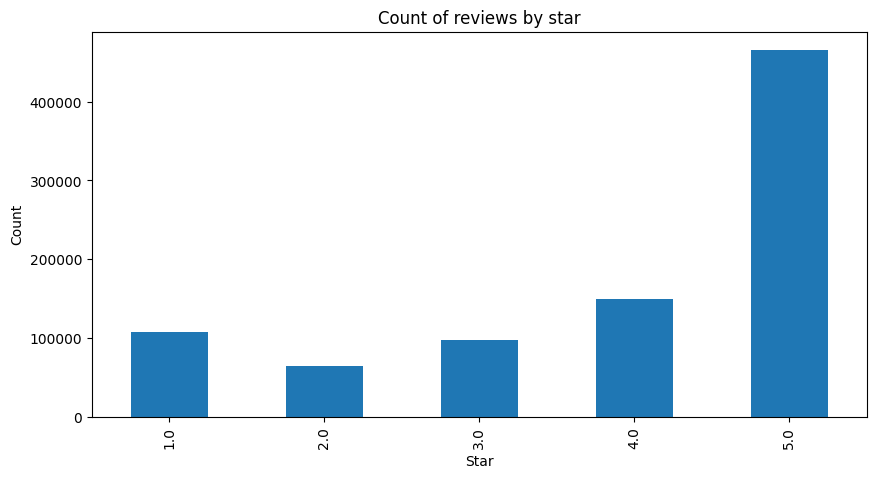

In [10]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")

notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## MODULO 2
### Rating Score
calculamos el overall mean

In [12]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


agregamos la columnas id al dataframe df_meta

In [13]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos la muestra para facilitar el procesamiento 

In [14]:
CANTIDAD = 10000

In [15]:
df_meta_cortado = df_meta.head(CANTIDAD)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [16]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta_cortado.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_meta_cortadoFrame 'df_meta_cortado'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta_cortado['combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


C:\Users\coraj\AppData\Local\Temp\ipykernel_13452\2222405249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_cortado['combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


La matriz vecs contiene las puntuaciones TF-IDF ( Frecuencia de Término - Frecuencia Inversa de Documento) para cada palabra en cada documento. Las puntuaciones TF-IDF representan la importancia de una palabra para un documento en la colección.

In [17]:
vec = TfidfVectorizer()
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(10000, 22929)

## Modulo 3
### Similarity Score

Esto significa que tienes 10000 documentos (las filas del DataFrame df_meta_cortado) y 22929 palabras únicas en todos los documentos (las características).

calcular la similitud del coseno entre cada par de vectores en vecs

Su valor varía de -1 (vectores completamente opuestos) a 1 (vectores idénticos), con 0 indicando ortogonalidad (vectores perpendiculares).

In [18]:
similaridad = cosine_similarity(vecs)
similaridad

array([[1.        , 0.00388052, 0.039671  , ..., 0.00938346, 0.00938346,
        0.00179705],
       [0.00388052, 1.        , 0.        , ..., 0.        , 0.        ,
        0.00467325],
       [0.039671  , 0.        , 1.        , ..., 0.1177269 , 0.1177269 ,
        0.        ],
       ...,
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00179705, 0.00467325, 0.        , ..., 0.        , 0.        ,
        1.        ]])

Maybe borrar?
maybe no

In [19]:
def fuzzificar(max, min, valor):
    intervalo = (max - min) / 4

    if valor <= min + intervalo:
        return "pesimo"
    elif valor <= min + 2 * intervalo:
        return "normal"
    elif valor <= min + 3 * intervalo:
        return "bueno"
    else:
        return "excelente"

In [20]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(similaridad[item_id]))
    sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
    # si score es mayor o igual a 1 entonces se elimina de la lista
    scores_no_1 = [i for i in sorted_scores if i[1]<0.8]
    # fuzzificar el score
    # scores_no_1 = [(score[0], fuzzificar(scores_no_1[0][1], scores_no_1[-1][1], score[1])) for score in scores_no_1]
    # sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in scores_no_1]
    return (items_selected, scores_no_1)

### Seleccionamos un producto aleatorio

Usamos el producto con ASIN = 1291691480

In [21]:
asins, similaridad_score = recommend('1291691480')
for i in range(2):
    print('Item ID: ',similaridad_score[i][0])
    print('Similarity Score: ',similaridad_score[i][1])
    print('ASIN: ',asins[i])
    print('\n')
    # Busca el 'overall_mean' correspondiente al 'asin'
    overall_mean_item = overall_mean.loc[overall_mean['asin'] == asins[i], 'overall']
    print('Overall Mean: ', overall_mean_item)
    print('\n')

Item ID:  3000
Similarity Score:  0.20165276828741638
ASIN:  B000Q4O5CY


Overall Mean:  3000    4.0
Name: overall, dtype: float64


Item ID:  5460
Similarity Score:  0.16068090381605266
ASIN:  B0020WB36G


Overall Mean:  5460    3.166667
Name: overall, dtype: float64




(0.0, 10000.0)

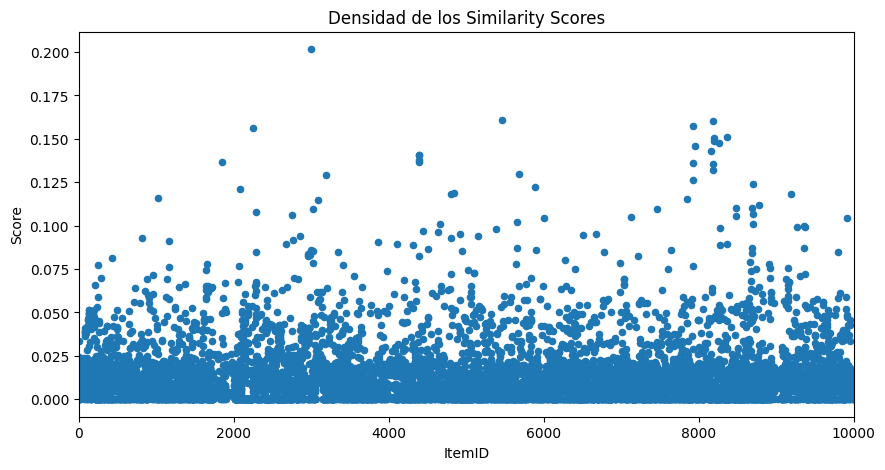

In [22]:
scores_df = pd.DataFrame(similaridad_score, columns=['ItemID', 'Score'])
ax = scores_df.plot.scatter(x='ItemID', y='Score', title="Densidad de los Similarity Scores", figsize=(10, 5))
ax.set_xlim(0, 10000)

In [27]:
top_score = [similaridad_score[i][1] for i in range(CANTIDAD - 1)]
top_item_id = [similaridad_score[i][0] for i in range(CANTIDAD - 1)]
top_asin = asins[:CANTIDAD]

# Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
data = list(zip(top_asin, top_score, top_item_id))

# Crear un DataFrame a partir de los datos combinados
df_result = pd.DataFrame(data, columns=['asin', 'Score', 'Id'])

# Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
final_result = pd.merge(df_result, overall_mean, on='asin')

# fuzzificar overall mean
final_result['overall_fuzzificado'] = final_result['overall'].apply(
    lambda valor: fuzzificar(5, 1, valor))

# Imprimir el resultado final
print(final_result)


            asin     Score    Id   overall overall_fuzzificado
0     B000Q4O5CY  0.201653  3000  4.000000               bueno
1     B0020WB36G  0.160681  5460  3.166667               bueno
2     B004GAK2TE  0.160325  8189  4.000000               bueno
3     B004BQJPJ6  0.157337  7920  4.000000               bueno
4     B000JFE6TM  0.156206  2252  5.000000           excelente
...          ...       ...   ...       ...                 ...
9994  B005914EJ8  0.000000  9991  2.000000              pesimo
9995  B00591YLEG  0.000000  9995  5.000000           excelente
9996  B00591XGD8  0.000000  9996  5.000000           excelente
9997  B00591VVDA  0.000000  9997  3.000000              normal
9998  B00591YFH4  0.000000  9998  4.000000               bueno

[9999 rows x 5 columns]


## MODULO 4
### Sistema de inferencia difuso

In [28]:
# Definimos las variables de entrada y salida para el sistema de control difuso
overall = ctrl.Antecedent(np.arange(1, 6, 0.1), 'overall')  # Calificación general
similaridad = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'similaridad')  # Similaridad con otros elementos
recomendacion = ctrl.Consequent(np.arange(0, 2, 0.1), 'recomendacion')  # Recomendación resultante

# Definimos los trapecios para las variables de entrada y salida
overall['excelente'] = fuzz.trapmf(overall.universe, [4.1, 5, 5, 5]) # si el valor es [4.1 o 5], entonces es excelente
overall['bueno'] = fuzz.trapmf(overall.universe, [3.1, 4, 4, 4.1]) # si el valor es [3.1 o 4.1), entonces es bueno
overall['normal'] = fuzz.trapmf(overall.universe, [2.1, 3, 3, 3.1]) # si el valor es [2.1 o 3.1), entonces es normal
overall['pesimo'] = fuzz.trapmf(overall.universe, [0.99, 2, 2, 2.1]) # si el valor es (0.99 o 2.1), entonces es pesimo

similaridad['muy_similar'] = fuzz.trapmf(similaridad.universe, [0.7, 1, 1, 1]) # si el valor es [0.7 o 1], entonces es muy similar
similaridad['similar'] = fuzz.trapmf(similaridad.universe, [0.4, 0.7, 0.7, 0.7]) # si el valor es [0.4 o 0.7), entonces es similar
similaridad['poco_similar'] = fuzz.trapmf(similaridad.universe, [0.2, 0.4, 0.4, 0.4]) # si el valor es [0.2 o 0.4), entonces es poco similar
similaridad['no_similar'] = fuzz.trapmf(similaridad.universe, [-1, 0, 0, 0.2])  # si el valor es [-1 o 0.2), entonces es no similar


recomendacion['muy_recomendado'] = fuzz.trapmf(recomendacion.universe, [1.1, 2, 2, 2]) # si el valor es [1.1 o 2], entonces es muy recomendado
recomendacion['recomendado'] = fuzz.trapmf(recomendacion.universe, [0.1, 1, 1, 1.1]) # si el valor es [0.1 o 1.1), entonces es recomendado
recomendacion['no_recomendado'] = fuzz.trapmf(recomendacion.universe, [0, 0, 0, 0.1]) # si el valor es [0 o 0.1), entonces es no recomendado

# regla 1: si la similaridad es no similar y el overall es excelente, bueno, normal o pesimo, entonces la recomendacion es no recomendado
rule1 = ctrl.Rule(similaridad['no_similar'] & (overall['excelente'] | overall['bueno'] | overall['normal'] | overall['pesimo']), recomendacion['no_recomendado'])
# regla 2: si la similaridad es muy similar, similar, poco similar o no similar y el overall es pesimo, entonces la recomendacion es no recomendado
rule2 = ctrl.Rule(overall['pesimo'] & (similaridad['muy_similar'] | similaridad['similar'] | similaridad['poco_similar'] | similaridad['no_similar']), recomendacion['no_recomendado'])
# regla 3: si la similaridad es muy similar o similar y el overall es excelente o bueno, entonces la recomendacion es muy recomendado
rule3 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['muy_recomendado'])
# regla 4: si la similaridad es muy similar o similar y el overall es normal, entonces la recomendacion es recomendado
rule4 = ctrl.Rule(overall['normal']  & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['recomendado'])
# regla 5: si la similaridad es muy similar o similar y el overall es excelente o bueno y poco similar, entonces la recomendacion es recomendado
rule5 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['poco_similar']), recomendacion['recomendado'])
# regla 6: si la similaridad es poco similar y el overall es normal, entonces la recomendacion es no recomendado
rule6 = ctrl.Rule(overall['normal'] & similaridad['poco_similar'], recomendacion['no_recomendado'])

# Sistema de control y simulación
sistema_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema_simulacion = ctrl.ControlSystemSimulation(sistema_control)

testeamos

In [29]:
# Pasar entradas al sistema
sistema_simulacion.input['overall'] = 4  # Ejemplo de calificación
sistema_simulacion.input['similaridad'] = 0.7  # Ejemplo de calificación
sistema_simulacion.compute() # Defuzzificación

print(sistema_simulacion.output['recomendacion'])

1.6333333333333335


## MODULO 5
### Defusificador

Defuzzificamos el resultado

In [30]:
def sistema_recomendacion_defuzzificado (recomendacion):
    if recomendacion < 0.1:
        return 'no_recomendado'
    elif recomendacion < 1.1:
        return 'recomendado'
    else:
        return 'muy_recomendado'
    

In [31]:
def sistema_recomendacion( similarity, overall):
    sistema_simulacion.input['overall'] = overall  # Ejemplo de calificación
    sistema_simulacion.input['similaridad'] = similarity # Ejemplo de calificación
    sistema_simulacion.compute() # Defuzzificación
    return (sistema_recomendacion_defuzzificado(sistema_simulacion.output['recomendacion']),sistema_simulacion.output['recomendacion'] )

In [32]:
# Aplicar la función fuzzyReglas a cada fila y crear una nueva columna 'result'
final_result['result'] = final_result.apply(lambda row: sistema_recomendacion(row['Score'], row['overall']), axis=1)

# Mostrar el DataFrame resultante
# contar todos los resultados igual a 'Highly Recommended'
final_result


,asin,Score,Id,overall,overall_fuzzificado,result
0,B000Q4O5CY,0.201653,3000,4.000000,bueno,"(recomendado, 0.6016504824734291)"
1,B0020WB36G,0.160681,5460,3.166667,bueno,"(no_recomendado, 0.04817188983855651)"
2,B004GAK2TE,0.160325,8189,4.000000,bueno,"(no_recomendado, 0.045222609143451546)"
3,B004BQJPJ6,0.157337,7920,4.000000,bueno,"(no_recomendado, 0.04487934731679524)"
4,B000JFE6TM,0.156206,2252,5.000000,excelente,"(no_recomendado, 0.04997070884592774)"
...,...,...,...,...,...,...
9994,B005914EJ8,0.000000,9991,2.000000,pesimo,"(no_recomendado, 0.03333333333333333)"
9995,B00591YLEG,0.000000,9995,5.000000,excelente,"(no_recomendado, 0.04997070884592774)"
9996,B00591XGD8,0.000000,9996,5.000000,excelente,"(no_recomendado, 0.04997070884592774)"
9997,B00591VVDA,0.000000,9997,3.000000,normal,"(no_recomendado, 0.03333333333333333)"


In [33]:
# Realizar un join entre final_result y dataset_original utilizando la columna 'ASIN' como clave de unión
resultado_completo = pd.merge(final_result, df_meta_cortado, on='asin')

# Imprimir el resultado completo
resultado_completo


,asin,Score,Id,overall,overall_fuzzificado,result,title,brand,feature,rank,...,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
0,B000Q4O5CY,0.201653,3000,4.000000,bueno,"(recomendado, 0.6016504824734291)",Kids Spider Character Brown Web Leather Band F...,Watch Pavilion,[Shipping Weight:\n \n3 pou...,"25,583,777inClothing,ShoesJewelry(",...,[New Spider watch with blue/red spider in cent...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,Kids Spider Character Brown Web Leather Band F...
1,B0020WB36G,0.160681,5460,3.166667,bueno,"(no_recomendado, 0.04817188983855651)","3"" Fantasy Spider Necklace Knife",NaN,NaN,"8,242,851inClothing,ShoesJewelry(",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5460,"3"" Fantasy Spider Necklace Knife nan nan"
2,B004GAK2TE,0.160325,8189,4.000000,bueno,"(no_recomendado, 0.045222609143451546)",Koto- 7.5 B - Black,Promise,[Package Dimensions:\n \n11...,"25,660,231inClothing,ShoesJewelry(",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8189,Koto- 7.5 B - Black Promise nan
3,B004BQJPJ6,0.157337,7920,4.000000,bueno,"(no_recomendado, 0.04487934731679524)",Rowland-6.0 B - Black,PROMISE,[Package Dimensions:\n \n10...,"25,711,210inClothing,ShoesJewelry(",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7920,Rowland-6.0 B - Black PROMISE nan
4,B000JFE6TM,0.156206,2252,5.000000,excelente,"(no_recomendado, 0.04997070884592774)",Spider-Man T-shirt,Shop Zeus,NaN,"26,311,438inClothing,ShoesJewelry(",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2252,Spider-Man T-shirt Shop Zeus nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,B005914EJ8,0.000000,9991,2.000000,pesimo,"(no_recomendado, 0.03333333333333333)",Crooks & Castles Women's Knit Cropped Hoodie-L...,Crooks & Castles,[Package Dimensions:\n \n11...,"14,629,888inClothing,ShoesJewelry(",...,[Cropped Hooded Sweatshirt100% Cotton French T...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9991,Crooks & Castles Women's Knit Cropped Hoodie-L...
9995,B00591YLEG,0.000000,9995,5.000000,excelente,"(no_recomendado, 0.04997070884592774)",Cheryl - BLACK KID LEATHER,Munro,[Package Dimensions:\n \n13...,"12,046,386inClothing,ShoesJewelry(",...,[This shoe has a very rounded toe shape and de...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9995,"Cheryl - BLACK KID LEATHER Munro [""This shoe h..."
9996,B00591XGD8,0.000000,9996,5.000000,excelente,"(no_recomendado, 0.04997070884592774)",Cheryl - BLACK KID LEATHER,Munro,[Package Dimensions:\n \n13...,"10,361,363inClothing,ShoesJewelry(",...,[This shoe has a very rounded toe shape and de...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9996,"Cheryl - BLACK KID LEATHER Munro [""This shoe h..."
9997,B00591VVDA,0.000000,9997,3.000000,normal,"(no_recomendado, 0.03333333333333333)",Cheryl - BLACK KID LEATHER,Munro,[Package Dimensions:\n \n13...,"14,245,395inClothing,ShoesJewelry(",...,[This shoe has a very rounded toe shape and de...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9997,"Cheryl - BLACK KID LEATHER Munro [""This shoe h..."
